In [41]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
def get_length(G_osm_graph,path):
    length=0
    for k in range(len(path)-1):
        length+=G_osm_graph.get_edge_data(path[k],path[k+1],0)['length']

    return length

def sub_ls(ls,pt1,pt2):
    l1,l2=ls.project(pt1),ls.project(pt2)
    if l2<l1:
        pt1,pt2,l1,l2=pt2,pt1,l2,l1
    coords=np.array(ls.coords)
    k1,length=0,0.
    while(length<l1):
        length+=np.linalg.norm(coords[k1+1]-coords[k1])
        k1+=1
    k2,length=len(coords)-1,ls.length
    while(length>l2):
        length-=np.linalg.norm(coords[k2]-coords[k2-1])
        k2-=1

    x1,y1=pt1.x,pt1.y
    x2,y2=pt2.x,pt2.y
    return np.array([[x1,y1]]+list(coords[k1:k2+1])+[[x2,y2]])

    
    
    

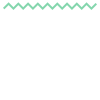

In [147]:
ls=LineString([(i,i%2) for i in range(20)])
ls

4.949747468305834 9.19238815542512
4 6
3.5 0.5 6.5 0.5


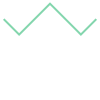

In [150]:
LineString(sub_ls(ls,Point(3.5,0.5),Point(6.5,0.5)))

In [42]:

user='spirz'
password='this_is_my_PASSWORD_m8'
host='localhost'
database='dem_from_contours_lines'
contours_lines_table_name='contours_lines'
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"


2

2

In [43]:
DBM=DataBaseManager(user=user,password=password,host=host,database=database,
            contours_lines_table_name=contours_lines_table_name,
            osm_nodes_table_name=osm_nodes_table_name,
            osm_edges_table_name=osm_edges_table_name,
            intersections_table_name=intersections_table_name)
2

2

In [44]:
t1=time.time()
place_name='Corse, France'
G_osm=ox.graph_from_place(place_name,network_type='drive')

t2=time.time()
print(t2-t1)


58.23194169998169


In [45]:
t1=time.time()
G_osm,osm_crs=preprocess_osm_graph(G_osm)
t2=time.time()
print(t2-t1)

13.161279201507568


In [46]:
G_osm_graph=nx.Graph(G_osm)

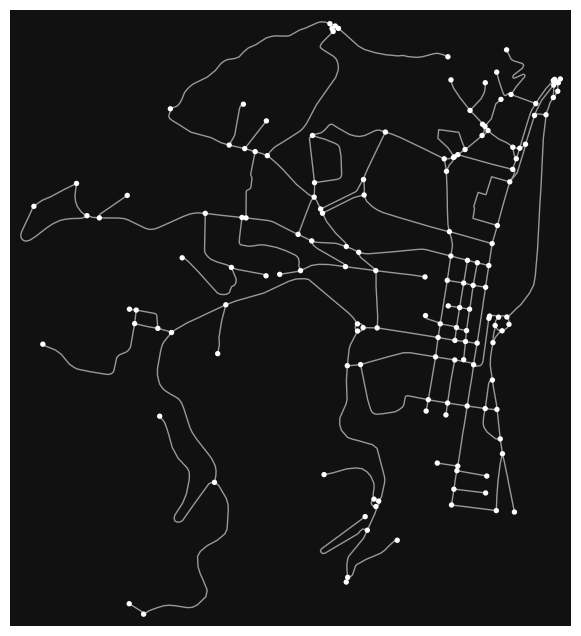

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [163]:
cutoff=10
max_length=2000
lat,lon=41.927901, 8.737424
pt=Point(lon,lat)
pt_df=gpd.GeoDataFrame([{'geometry':pt}],crs='epsg:4326').to_crs(osm_crs)
pt=pt_df.iloc[0]['geometry']
x,y=pt.x,pt.y
source=ox.nearest_nodes(G_osm,[x],[y])[0]
lengths=[(node,get_length(G_osm_graph,path)) for node,path in nx.single_source_shortest_path(G_osm_graph,source,cutoff=cutoff).items()]
nodes=[node for node,length in lengths if length<max_length]
sub_G_osm=nx.subgraph(G_osm,nodes)
sub_G_osm=nx.subgraph(G_osm,nodes).copy()
sub_G_osm.remove_edges_from([(u,v) for u,v in sub_G_osm.edges() if u==v])
ox.plot_graph(sub_G_osm)


In [164]:
edges=tuple(sub_G_osm.edges(keys=True))
cmd="SELECT osm_begin,osm_end,osm_key,edge_coordinate,elevation,contour_id,ST_asText(geometry) AS geometry FROM %s WHERE (osm_begin,osm_end,osm_key) IN %s OR (osm_end,osm_begin,osm_key) IN %s"%(DBM.intersections_table_name,str(edges),str(edges))
DBM.cursor.execute(cmd)
intersection_df=pd.DataFrame(DBM.cursor.fetchall())
intersection_df['geometry']=intersection_df['geometry'].apply(lambda pt:loads(pt))
intersection_df=gpd.GeoDataFrame(intersection_df,geometry='geometry',crs='epsg:4326')
intersection_df=intersection_df.to_crs(osm_crs)
intersection_df['edge']=intersection_df.apply(lambda row:(row['osm_begin'],row['osm_end'],row['osm_key']),axis=1)
contour_ids=intersection_df['contour_id'].unique()
#contour_ids=[elem['contour_id'] for elem in DBM.cursor.fetchall()]
contours_df=DBM.get_nodes_data(contour_ids)
contours_df=contours_df.to_crs(osm_crs)

(4640948.0629332615, 4642449.678023773)

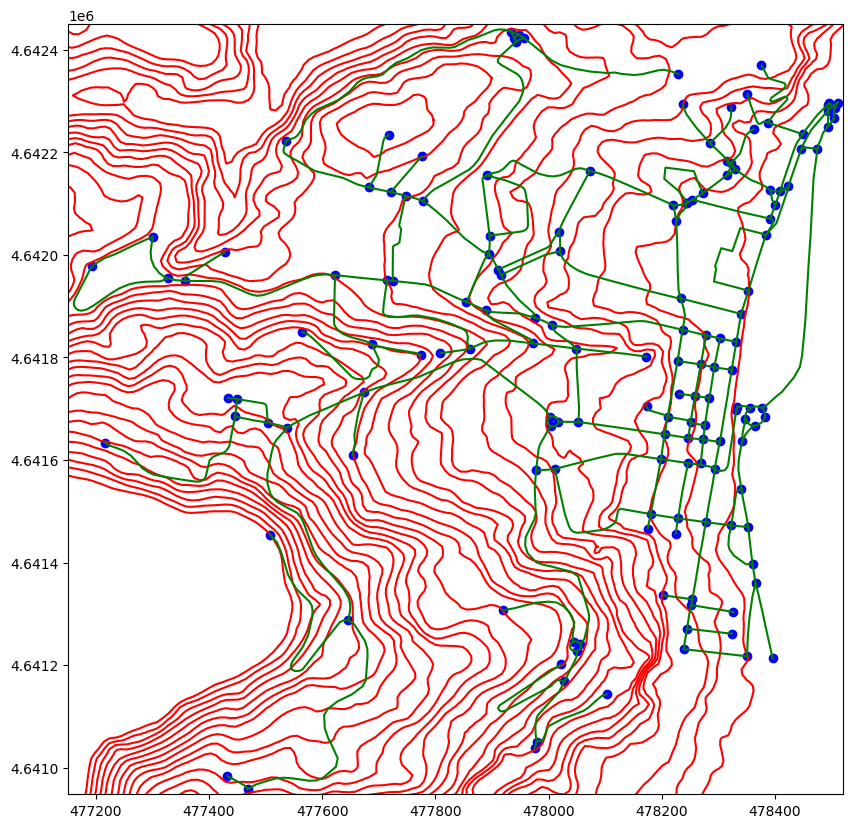

In [165]:
plt.rcParams['figure.figsize']=(10,10)
offset=10
x_min,x_max,y_min,y_max=None,None,None,None
for _,row in contours_df.iterrows():
    coords=np.array(row['geometry'].coords)
    plt.plot(coords[:,0],coords[:,1],c='r')
for _,data in sub_G_osm.nodes(data=True):
    plt.scatter(data['x'],data['y'],c='b')
for _,_,_,data in sub_G_osm.edges(data=True,keys=True):
    coords=np.array(data['geometry'].coords)
    plt.plot(coords[:,0],coords[:,1],c='g')
    if x_min is None:
        x_min=np.min(coords[:,0])
    else:
        x_min=min(x_min,np.min(coords[:,0]))
    if x_max is None:
        x_max=np.max(coords[:,0])
    else:
        x_max=max(x_max,np.max(coords[:,0]))
    if y_min is None:
        y_min=np.min(coords[:,1])
    else:
        y_min=min(y_min,np.min(coords[:,1]))
    if y_max is None:
        y_max=np.max(coords[:,1])
    else:
        y_max=max(y_max,np.max(coords[:,1]))
x_min-=offset
y_min-=offset
x_max+=offset
y_max+=offset
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)



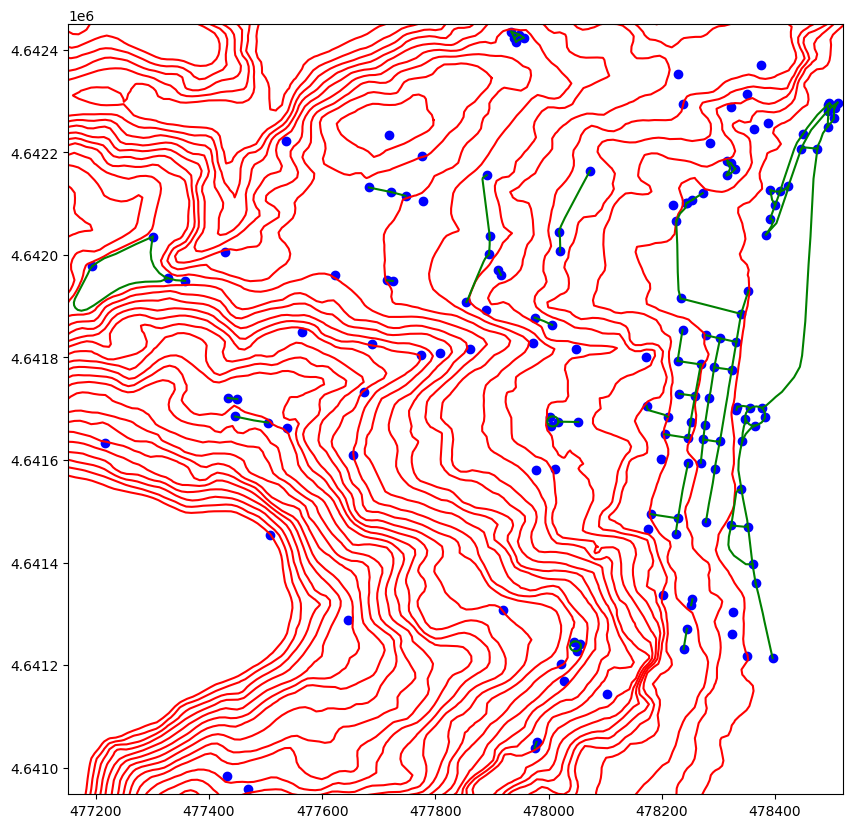

In [166]:
intersecting_edges=list(intersection_df['edge'].unique())
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
for _,row in contours_df.iterrows():
    coords=np.array(row['geometry'].coords)
    plt.plot(coords[:,0],coords[:,1],c='r')

for _,data in sub_G_osm.nodes(data=True):
    plt.scatter(data['x'],data['y'],c='b')

for begin,end,key,data in sub_G_osm.edges(data=True,keys=True):
    if not((begin,end,key) in intersecting_edges or (end,begin,key) in intersecting_edges):
        coords=np.array(data['geometry'].coords)
        plt.plot(coords[:,0],coords[:,1],c='g')

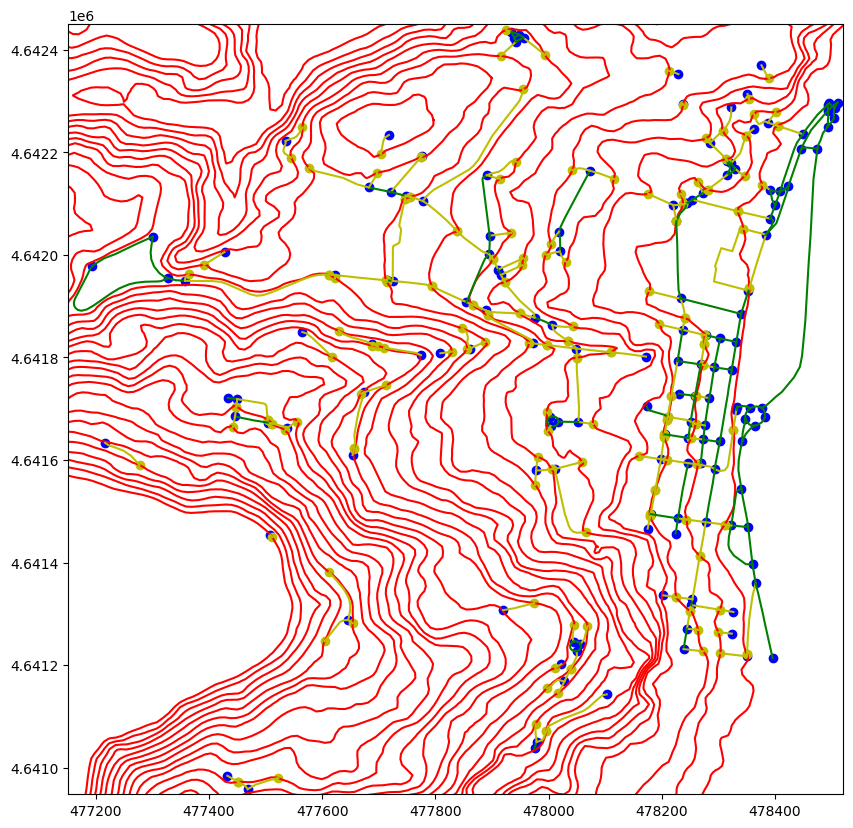

In [169]:
intersecting_edges=list(intersection_df['edge'].unique())
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
for _,row in contours_df.iterrows():
    coords=np.array(row['geometry'].coords)
    plt.plot(coords[:,0],coords[:,1],c='r')

for _,data in sub_G_osm.nodes(data=True):
    plt.scatter(data['x'],data['y'],c='b')

for begin,end,key,data in sub_G_osm.edges(data=True,keys=True):
    if (begin,end,key) in intersecting_edges:
        sub_intersection=intersection_df[intersection_df.edge==(begin,end,key)]
        sub_intersection=sub_intersection.sort_values('edge_coordinate')
        ls=data['geometry']
        if end in nodes:
            last_intersection=sub_intersection.iloc[-1]
            pt_last=last_intersection['geometry']
            pt_end=Point(sub_G_osm.nodes()[end]['x'],sub_G_osm.nodes()[end]['y'])
            coords=sub_ls(ls,pt_last,pt_end)
            plt.plot(coords[:,0],coords[:,1],c='y')
            plt.scatter(pt_last.x,pt_last.y,c='y')

        if begin in nodes:
            first_intersection=sub_intersection.iloc[0]
            pt_first=first_intersection['geometry']
            pt_begin=Point(sub_G_osm.nodes()[begin]['x'],sub_G_osm.nodes()[begin]['y'])
            coords=sub_ls(ls,pt_begin,pt_first)
            plt.plot(coords[:,0],coords[:,1],c='y')
            plt.scatter(pt_first.x,pt_first.y,c='y')


    elif (end,begin,key) in intersecting_edges:
        sub_intersection=intersection_df[intersection_df.edge==(end,begin,key)]
        sub_intersection=sub_intersection.sort_values('edge_coordinate')
        ls=data['geometry']
        if end in nodes:
            print('yo')
            last_intersection=sub_intersection.iloc[-1]
            pt_last=last_intersection['geometry']
            pt_end=Point(sub_G_osm.nodes()[end]['x'],sub_G_osm.nodes()[end]['y'])
            coords=sub_ls(ls,pt_last,pt_end)
            plt.plot(coords[:,0],coords[:,1],c='y')
            plt.scatter(pt_last.x,pt_last.y,c='y')

        if begin in nodes:
            print('wesh')
            first_intersection=sub_intersection.iloc[0]
            pt_first=first_intersection['geometry']
            pt_begin=Point(sub_G_osm.nodes()[begin]['x'],sub_G_osm.nodes()[begin]['y'])
            coords=sub_ls(ls,pt_begin,pt_first)
            plt.plot(coords[:,0],coords[:,1],c='y')
            plt.scatter(pt_first.x,pt_first.y,c='y')

        


    else:
        coords=np.array(data['geometry'].coords)
        plt.plot(coords[:,0],coords[:,1],c='g')